In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import pylab as pl
import sklearn.cross_validation, sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
import scipy.stats
import xgboost as xgb

%matplotlib inline
pd.set_option('display.mpl_style', 'default')
pl.rcParams['figure.figsize'] = (20, 10)

column_dtypes = {'ScanCount': 'int8'}

train = pd.read_csv('train.csv', low_memory=False, dtype=column_dtypes)
test = pd.read_csv('test.csv', low_memory=False, dtype=column_dtypes)
types = np.unique(train.TripType.values)
types_dictionary = {t: i for i, t in  enumerate(types)}

In [2]:
def transform_Upc(data):
    data['UpcPrefix'] = data.Upc.map(lambda x: x // 10**10 % 10 ).astype('int8')
    data['UpcManufacturer'] = data.Upc.map(lambda x: (x // 10**5) - (x // 10**10)*10**5 ).astype('int32')
    data['UpcProduct'] = data.Upc.map(lambda x: x % 10**5).astype('int32')
    data.ix[data.Upc == -1, ['UpcPrefix', 'UpcManufacturer', 'UpcProduct']] = -1
    del data['Upc']
    return data

def preprocess_columns(data):
    data.Upc = data.Upc.fillna(-1)
    data.FinelineNumber = data.FinelineNumber.fillna(-1)
    data = transform_Upc(data)
    data.FinelineNumber = data.FinelineNumber.astype('int16')
    return data

train = preprocess_columns(train)
test = preprocess_columns(test)


In [3]:
def get_frequence_feature(feature):
    dict_counts = dict(feature.value_counts())
    series = feature.map(lambda x: dict_counts[x])
    return (series - series.min())/(series.max() - series.min())

def encode_features(data):
    data['FinelineNumberFreq'] = get_frequence_feature(data.FinelineNumber)
    data['UpcManufacturerFreq'] = get_frequence_feature(data.UpcManufacturer)
    data['UpcProductFreq'] = get_frequence_feature(data.UpcProduct)
    
    return data

data = train.append(test)
data = encode_features(data)
train = data[:len(train)]
test = data[len(train):]

del data, test['TripType']

In [4]:
def at(l):
    return l.iloc[0]
def mklist(l):
    return list(l)

train_grouped = train.groupby('VisitNumber').agg({'TripType': at, 'Weekday': at, 'ScanCount': mklist, 
                                                  'DepartmentDescription': at, 'FinelineNumberFreq': mklist,
                                                  'UpcPrefix': mklist, 'UpcManufacturerFreq': mklist,
                                                  'UpcProductFreq': mklist}).reset_index()
test_grouped = test.groupby('VisitNumber').agg({'Weekday': at, 'ScanCount': mklist, 'DepartmentDescription': at, 
                                                'FinelineNumberFreq': mklist, 'UpcPrefix': mklist,
                                                'UpcManufacturerFreq': mklist, 'UpcProductFreq': mklist}).reset_index()

In [5]:
def construct_grouped_features(data):
    
    data['LogNumberOfReturned'] = data.ScanCount.map(lambda x: np.log(-sum([a for a in x if a < 0]) + 1))
    data['LogNumberOfPurchased'] = data.ScanCount.map(lambda x: np.log(sum([a for a in x if a > 0]) + 1))
    data['MedianScanCount'] = data.ScanCount.map(lambda x: np.median(x))
    data['StdScanCount'] = data.ScanCount.map(lambda x: np.std(x))
    
    for i in [j for j in range(10) if j != 5]: #[0,2,3,6,7,8]
        data['UpcPrefix_' + str(i)] = data.UpcPrefix.map(lambda x: x.count(i))
    
    data['MedianFinelineNumberFreq'] = data.FinelineNumberFreq.map(lambda x: np.median(x))
    data['MedianUpcManufacturerFreq'] = data.UpcManufacturerFreq.map(lambda x: np.median(x))
    data['MedianUpcProductFreq'] = data.UpcProductFreq.map(lambda x: np.median(x))
    
    data['StdRelUMrUpt'] = data.apply(lambda r: 
                                      np.std(np.log(np.array(r.UpcManufacturerFreq)/np.array(r.UpcProductFreq) + 1)), axis=1)
    data['StdRelUMrUpt'] = data.apply(lambda r: 
                                      np.std(np.log(np.array(r.UpcManufacturerFreq)/np.array(r.UpcProductFreq) + 1)), axis=1)
    
    
    data['SumSnCtFlNFreq'] = data.apply(lambda r: sum(np.array(r.FinelineNumberFreq)*np.array(r.ScanCount)), axis=1)
    data['SumSnCtUPtFreq'] = data.apply(lambda r: sum(np.array(r.UpcProductFreq)*np.array(r.ScanCount)), axis=1)
    data['SumSnCtUMrFreq'] = data.apply(lambda r: sum(np.array(r.UpcManufacturerFreq)*np.array(r.ScanCount)), axis=1)
    
    data['StdSnCtFlNFreq'] = data.apply(lambda r: np.std(np.array(r.FinelineNumberFreq)*np.array(r.ScanCount)), axis=1)
    data['StdSnCtUPtFreq'] = data.apply(lambda r: np.std(np.array(r.UpcProductFreq)*np.array(r.ScanCount)), axis=1)
    data['StdSnCtUMrFreq'] = data.apply(lambda r: np.std(np.array(r.UpcManufacturerFreq)*np.array(r.ScanCount)), axis=1)
    
    
    data['MaxFlNnUptnUMr'] = data.apply(lambda r:
                                        np.max(np.array(r.UpcProductFreq) + np.array(r.UpcManufacturerFreq) +
                                               np.array(r.FinelineNumberFreq)), axis=1)
    data['MedianFlNnUptnUMr'] = data.apply(lambda r:
                                        np.median(np.array(r.UpcProductFreq) + np.array(r.UpcManufacturerFreq) +
                                               np.array(r.FinelineNumberFreq)), axis=1)
    
    return data

train_grouped = construct_grouped_features(train_grouped)
test_grouped = construct_grouped_features(test_grouped)

#####Plotting distribution of generated features

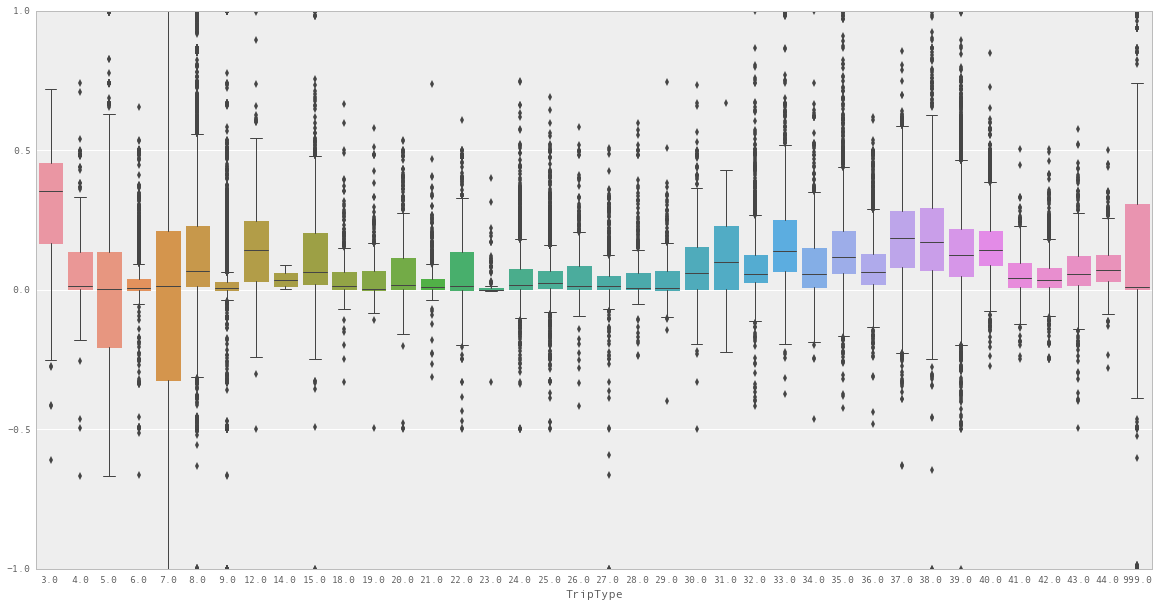

In [122]:
sns.boxplot(train_grouped.sort('TripType').TripType, 
            train_grouped.sort('TripType').apply(lambda r:
                                np.mean(np.array(r.UpcManufacturerFreq) - np.array(r.UpcProductFreq)), axis=1))


In [7]:
def construct_dummy_features(data, dummy_columns):
    data = pd.get_dummies(data, sparse=True, dummy_na=False, columns=dummy_columns)
    return data

In [8]:
expanded_features = ['UpcPrefix', 'UpcManufacturerFreq', 'UpcProductFreq', 'FinelineNumberFreq', 'ScanCount']

data = train_grouped.append(test_grouped)
data = data[[col for col in data.columns if col not in expanded_features]]

data = construct_dummy_features(data, ['Weekday', 'DepartmentDescription'])

train_dummies = data.iloc[:len(train_grouped)]
test_dummies = data.iloc[len(train_grouped):]
del data, test_dummies['TripType']
print(len(test_dummies.columns), 'features constructed')
print('Memory usage of dataframe train_dummies is %3.2f Mb' % (train_dummies.memory_usage(index=True).sum()/(1024*1024)))
print('Memory usage of dataframe test_dummies is %3.2f Mb' % (test_dummies.memory_usage(index=True).sum()/(1024*1024)))

102 features constructed
Memory usage of dataframe train_dummies is 22.63 Mb
Memory usage of dataframe test_dummies is 21.90 Mb


In [9]:
# del train, test, train_grouped, test_grouped

In [10]:
def get_prior_probabilities(data):
    prior_probabilities = np.zeros(len(types))
    prior_probabilities += np.array([len(data[data.TripType == trip_type]) for trip_type in types])
    prior_probabilities /= prior_probabilities.sum()
    return prior_probabilities

In [11]:
def fit_predict(train_array, train_labels, test_array, prior_probabilities=None, algorithm='rf', alpha=None, 
                plot_importance=True, feature_names=None):
    if algorithm == 'xgb':
        clf = xgb.XGBClassifier(n_estimators=30, max_depth=9, learning_rate=0.3, objective='multi:softprob', 
                                colsample_bytree=0.4, subsample=0.4, seed=41621)
        clf.fit(train_array, train_labels)
        prediction_matrix = clf.predict_proba(test_array)
        
        if plot_importance and feature_names:
            with open('xgb.fmap', 'w') as outfile:
                for i, feature_name in enumerate(feature_names):
                    outfile.write('{0}\t{1}\tq\n'.format(i, feature_name))
            importances = clf.booster().get_fscore('xgb.fmap')
            feature_names = list(importances.keys())
            importances = np.array(list(importances.values()))
            pl.title('Feature Importance')
            sorted_indices = np.argsort(importances)[::-1]
            for i, k in enumerate(sorted_indices):
                print('%2d (feature %2d):' % (i, k), feature_names[k], 'Value = %.5f' % importances[k])
            print([feature_names[k] for k in sorted_indices])
            sns.barplot(np.arange(len(feature_names)), importances[sorted_indices], color='r')
                        
    elif algorithm in ['rf']:
        if algorithm == 'rf':
            clf = RandomForestClassifier(n_estimators=150, max_depth=20, min_samples_leaf=1, max_features=0.2, n_jobs=-1)
        clf.fit(train_array, train_labels)
        prediction_matrix = clf.predict_proba(test_array)
        if plot_importance and feature_names:
            importances = clf.feature_importances_
            std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)
            pl.title('Feature Importance')
            sorted_indices = np.argsort(importances)[::-1]
            for i, k in enumerate(sorted_indices):
                print('%2d (feature %2d):' % (i, k), feature_names[k], 'Value = %.5f' % importances[k])
#             print([feature_names[k] for k in sorted_indices])

            pl.bar(range(len(feature_names)), importances[sorted_indices], color='r',
                   yerr=std[sorted_indices], align='center')
            pl.xticks(range(len(feature_names)), sorted_indices)
            pl.xlim([-1, len(feature_names) + 1])
    
    elif algorithm in ['logit', 'sgd']:
        if algorithm == 'logit':
            clf = LogisticRegressionCV(Cs=5, n_jobs=-1)
        elif algorithm == 'sgd':
            clf = SGDClassifier(loss='log', n_jobs=-1, alpha=10**6, class_weight='balanced')
        clf.fit(train_array, train_labels)
        prediction_matrix = clf.predict_proba(test_array)
        
    if not prior_probabilities is None:
        coeff = 0.1
        prediction_matrix = (prediction_matrix + [prior_probabilities*coeff]*len(prediction_matrix))/(1. + coeff)
    return prediction_matrix

In [123]:
def train_and_score(train_dummies, grid_space=[0], algorithm='rf', plot_importance=True, plot_errors=True):
    if len(grid_space) > 1:
        alphas, scores = [], []
        min_alpha, min_score = 1., 10**5
    
    for alpha in grid_space:
        if len(grid_space) > 1:
            print('alpha =', alpha)
        y = train_dummies.TripType.values
        for train_indices, test_indices in sklearn.cross_validation.StratifiedShuffleSplit(y, n_iter=1, test_size=0.1):
            data_train = train_dummies.iloc[train_indices]
            data_test = train_dummies.iloc[test_indices]

    #         prior_probabilities = get_prior_probabilities(data_train)
            feature_names = [col for col in data_train.columns if col not in ['TripType']]
            
            prediction_matrix = fit_predict(data_train[feature_names].values, 
                                            data_train.TripType.values, 
                                            data_test[feature_names].values, 
                                            algorithm=algorithm, alpha=alpha, plot_importance=plot_importance, 
                                            feature_names=feature_names)

            prediction_matrix = np.delete(prediction_matrix, 7, axis=1)
            y_true = data_test.TripType.values
            
            mlogloss = sklearn.metrics.log_loss(y_true, prediction_matrix) 
            
            print('mlogloss =', mlogloss, end='\n\n')
            if plot_errors:
                df = pd.DataFrame(y_true, columns=['TripType'])
                df['Proba'] = 0
                for i, y in enumerate(np.unique(y_true)):
                    df.ix[df.TripType == y, 'Proba'] = 1 - prediction_matrix[y_true == y, i]
                f, ax = pl.subplots()
                df = df.sort('TripType')
                sns.boxplot(df.TripType, df.Proba, ax=ax)
                f.savefig('proba_errors.png')
            
            if len(grid_space) > 1:
                alphas.append(alpha)
                scores.append(mlogloss)
                if mlogloss <= min_score:
                    min_score = mlogloss
                    min_alpha = alpha
    if len(grid_space) > 1:
        return alphas, scores, min_alpha, min_score
    else:
        return mlogloss

##MAIN

In [24]:
train_dump = train_dummies
test_dump = test_dummies

In [105]:
feature_selection = ['StdRelUMrUpt', 'MedianFinelineNumberFreq', 'VisitNumber', 'MedianFlNnUptnUMr', 'SumSnCtUMrFreq', 'StdSnCtFlNFreq', 'SumSnCtUPtFreq', 'SumSnCtFlNFreq', 'MedianUpcManufacturerFreq', 'MaxFlNnUptnUMr', 'StdSnCtUMrFreq', 'MedianUpcProductFreq', 'StdFlNnUptnUMr', 'StdSnCtUPtFreq', 'LogNumberOfPurchased', 'StdScanCount', 'UpcPrefix_0', 'UpcPrefix_8', 'UpcPrefix_6', 'UpcPrefix_7', 'MedianScanCount', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Monday', 'UpcPrefix_3', 'Weekday_Friday', 'Weekday_Tuesday', 'Weekday_Thursday', 'Weekday_Wednesday', 'LogNumberOfReturned']
train_dummies = train_dump[feature_selection + ['TripType']]
test_dummies = test_dump[feature_selection]

In [121]:
train_dummies = train_dump
test_dummies = test_dump
del train_dump, test_dump

/home/oem/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


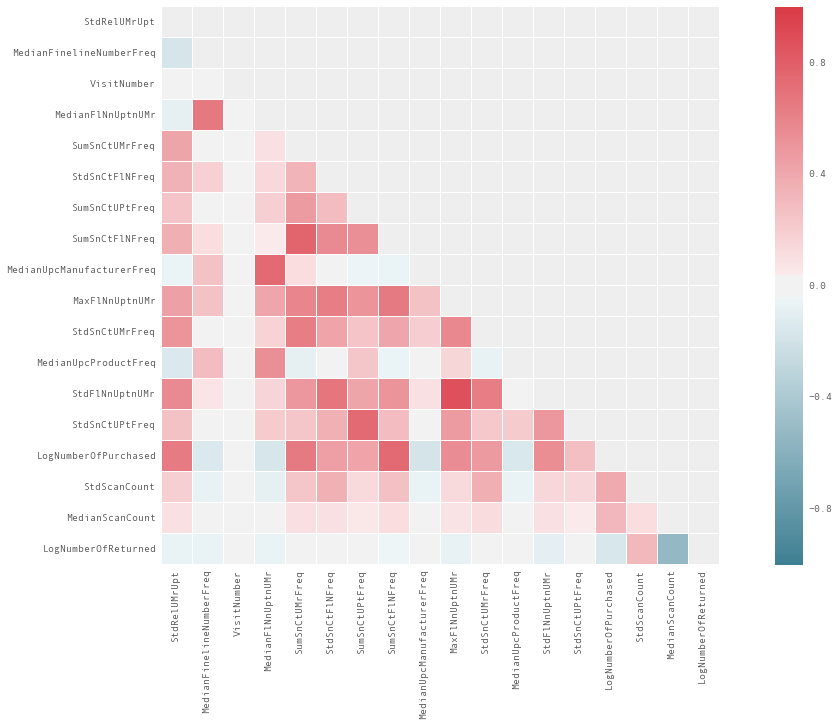

In [106]:
columns = [col for col in test_dummies.columns 
           if not any([col.startswith(name) for name in ['Weekday', 'UpcPrefix', 'Department']])]
corr = train_dummies[columns].append(test_dummies[columns]).corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, square=True, robust=True, linewidths=0.2, annot=False)

 0 (feature 52): StdRelUMrUpt Value = 6654.00000
 1 (feature 41): MedianFinelineNumberFreq Value = 6508.00000
 2 (feature 69): VisitNumber Value = 6269.00000
 3 (feature 64): MedianFlNnUptnUMr Value = 5970.00000
 4 (feature 12): SumSnCtUMrFreq Value = 5921.00000
 5 (feature 66): SumSnCtUPtFreq Value = 5669.00000
 6 (feature 84): SumSnCtFlNFreq Value = 5664.00000
 7 (feature 55): StdSnCtFlNFreq Value = 5569.00000
 8 (feature 19): MaxFlNnUptnUMr Value = 5466.00000
 9 (feature 70): MedianUpcManufacturerFreq Value = 5450.00000
10 (feature 36): StdSnCtUMrFreq Value = 5146.00000
11 (feature 94): MedianUpcProductFreq Value = 4952.00000
12 (feature 58): StdFlNnUptnUMr Value = 4811.00000
13 (feature 57): StdSnCtUPtFreq Value = 4417.00000
14 (feature 13): StdScanCount Value = 2671.00000
15 (feature 45): LogNumberOfPurchased Value = 2629.00000
16 (feature  0): UpcPrefix_0 Value = 2567.00000
17 (feature  9): UpcPrefix_8 Value = 1226.00000
18 (feature  2): UpcPrefix_6 Value = 1213.00000
19 (feature

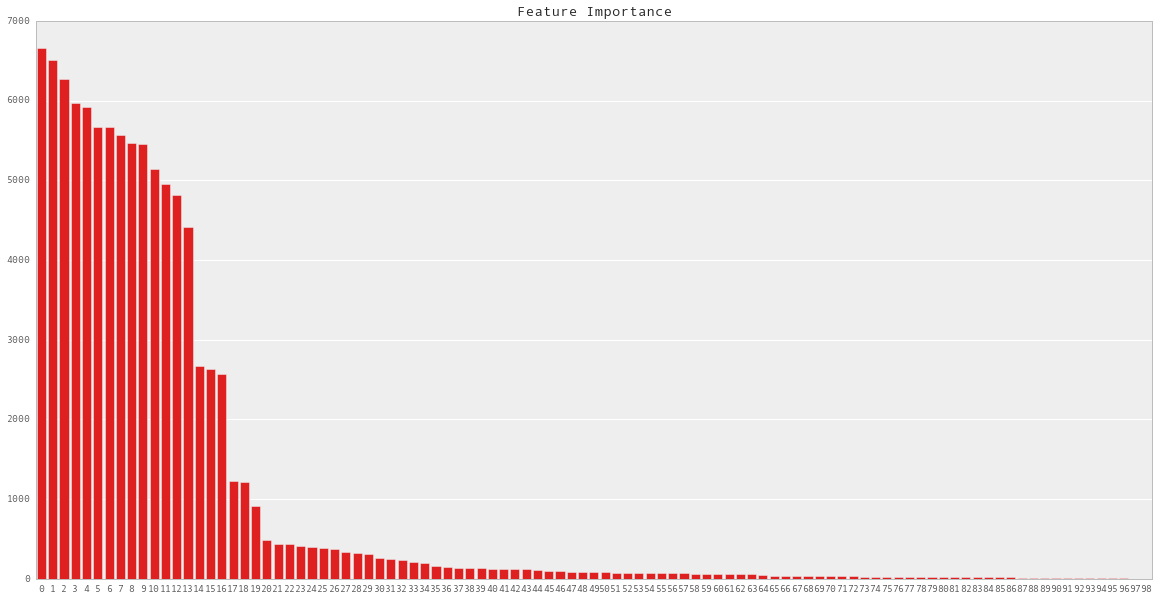

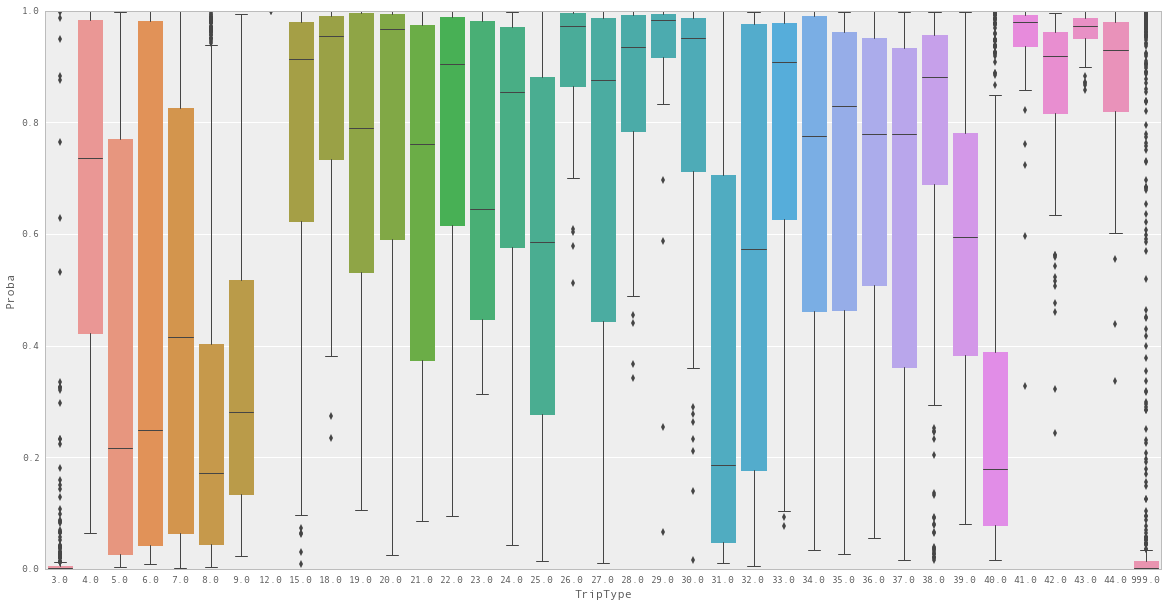

In [124]:
algorithms = ['rf', 'xgb', 'logit', 'sgd']
algorithm = 'xgb'

validation = True

if validation:
    
    compute_optimal = False
    if compute_optimal:
        grid_space = np.linspace(10**3, 10**6, 10)
        alphas, scores, min_alpha, min_score = train_and_score(train_dummies, grid_space=grid_space,
                                                               algorithm=algorithm, plot_importance=False)
        print('MIN ALPHA =', min_alpha, 'MIN_MLOGLOSS =', min_score)
        pl.plot(alphas, scores, 'r.--')
    else:
        mlogloss = train_and_score(train_dummies, algorithm=algorithm)
    
elif not validation:
#     prior_probabilities = get_prior_probabilities(train)
    prediction_matrix = fit_predict(train_dummies[[col for col in train_dummies.columns 
                                                   if col not in ['TripType']]].values, 
                                    train_dummies.TripType.values, test_dummies.values, algorithm=algorithm)
    
    prediction_df = pd.DataFrame(prediction_matrix, columns=['TripType_' + str(i) for i in types])
    prediction_df['VisitNumber'] = test_dummies.VisitNumber.values
    
    prediction_df = prediction_df[['VisitNumber'] + [x for x in prediction_df.columns if x != 'VisitNumber']]
    del prediction_matrix
    
    filename = 'prediction.csv'
    prediction_df.to_csv(filename, index=False)
    print(filename, 'was created')
    del prediction_df
    

['StdRelUMrUpt', 'MedianFinelineNumberFreq', 'VisitNumber', 'MedianFlNnUptnUMr', 'SumSnCtUMrFreq', 'StdSnCtFlNFreq', 'SumSnCtUPtFreq', 'SumSnCtFlNFreq', 'MedianUpcManufacturerFreq', 'MaxFlNnUptnUMr', 'StdSnCtUMrFreq', 'MedianUpcProductFreq', 'StdFlNnUptnUMr', 'StdSnCtUPtFreq', 'LogNumberOfPurchased', 'StdScanCount', 'UpcPrefix_0', 'UpcPrefix_8', 'UpcPrefix_6', 'UpcPrefix_7', 'MedianScanCount', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Monday', 'UpcPrefix_3', 'Weekday_Friday', 'Weekday_Tuesday', 'Weekday_Thursday', 'Weekday_Wednesday', 'LogNumberOfReturned', 'DepartmentDescription_DSD GROCERY', 'DepartmentDescription_IMPULSE MERCHANDISE', 'DepartmentDescription_GROCERY DRY GOODS', 'DepartmentDescription_PERSONAL CARE', 'DepartmentDescription_PRODUCE', 'UpcPrefix_2', 'DepartmentDescription_DAIRY', 'DepartmentDescription_PHARMACY OTC', 'DepartmentDescription_HOUSEHOLD CHEMICALS/SUPP', 'DepartmentDescription_MENS WEAR', 'DepartmentDescription_FROZEN FOODS', 'DepartmentDescription_HOUSEHOLD PAPER GOODS', 'DepartmentDescription_BAKERY', 'DepartmentDescription_BEAUTY', 'UpcPrefix_9', 'DepartmentDescription_CANDY, TOBACCO, COOKIES', 'DepartmentDescription_FINANCIAL SERVICES', 'DepartmentDescription_TOYS', 'DepartmentDescription_OFFICE SUPPLIES', 'DepartmentDescription_COMM BREAD', 'DepartmentDescription_CELEBRATION', 'DepartmentDescription_SHOES', 'DepartmentDescription_AUTOMOTIVE', 'DepartmentDescription_HARDWARE', 'DepartmentDescription_PETS AND SUPPLIES', 'DepartmentDescription_ELECTRONICS', 'DepartmentDescription_INFANT CONSUMABLE HARDLINES', 'DepartmentDescription_HOME MANAGEMENT', 'DepartmentDescription_LAWN AND GARDEN', 'DepartmentDescription_SPORTING GOODS', 'DepartmentDescription_COOK AND DINE', 'DepartmentDescription_SERVICE DELI', 'DepartmentDescription_LADIESWEAR', 'DepartmentDescription_FABRICS AND CRAFTS', 'DepartmentDescription_MEDIA AND GAMING', 'DepartmentDescription_HOME DECOR', 'DepartmentDescription_MEAT - FRESH & FROZEN', 'DepartmentDescription_LIQUOR,WINE,BEER', 'DepartmentDescription_JEWELRY AND SUNGLASSES', 'DepartmentDescription_PRE PACKED DELI', 'DepartmentDescription_INFANT APPAREL', 'DepartmentDescription_WIRELESS', 'DepartmentDescription_PAINT AND ACCESSORIES', 'DepartmentDescription_BATH AND SHOWER', 'DepartmentDescription_GIRLS WEAR, 4-6X  AND 7-14', 'DepartmentDescription_1-HR PHOTO', 'DepartmentDescription_BOYS WEAR', 'DepartmentDescription_PHARMACY RX', 'UpcPrefix_1', 'DepartmentDescription_HORTICULTURE AND ACCESS', 'DepartmentDescription_PLAYERS AND ELECTRONICS', 'DepartmentDescription_BEDDING', 'DepartmentDescription_OPTICAL - FRAMES', 'UpcPrefix_4', 'DepartmentDescription_FURNITURE', 'DepartmentDescription_BOOKS AND MAGAZINES', 'DepartmentDescription_BRAS & SHAPEWEAR', 'DepartmentDescription_ACCESSORIES', 'DepartmentDescription_SLEEPWEAR/FOUNDATIONS', 'DepartmentDescription_OPTICAL - LENSES', 'DepartmentDescription_CAMERAS AND SUPPLIES', 'DepartmentDescription_SWIMWEAR/OUTERWEAR', 'DepartmentDescription_SEAFOOD', 'DepartmentDescription_CONCEPT STORES', 'DepartmentDescription_PLUS AND MATERNITY', 'DepartmentDescription_SHEER HOSIERY', 'DepartmentDescription_LADIES SOCKS', 'DepartmentDescription_OTHER DEPARTMENTS', 'DepartmentDescription_MENSWEAR']